In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryPrecision

import math
from string import digits

In [3]:
df = pd.read_csv("data/ML_text_data.csv")

In [18]:
def clean_text(text):
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = text.replace("HOUSE BILL", "")
    text = text.replace("SENATE BILL", "")
    text = re.sub(" {2,}", " ", text)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    return text

In [19]:
df['clean_text'] = df['text'].apply(lambda x: clean_text(x))

In [22]:
len(df)

2660

In [65]:
data = zip(df['discriminatory'], df['text'])

In [5]:
from string import digits

In [24]:
def clean_text(text):
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = re.sub(" {2,}", " ", text)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    return text

In [23]:
tokenizer = get_tokenizer('basic_english')

In [25]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        text = clean_text(text)
        text = tokenizer(text)
        yield text

In [27]:
vocab = build_vocab_from_iterator(
    yield_tokens(data), specials=["<unk>"], min_freq=100)

In [28]:
vocab.set_default_index(vocab["<unk>"])

In [29]:
# Checking the result
print(len(vocab))
print(vocab.lookup_token(0))
print(vocab.lookup_token(15))
print(vocab["bill"])
print(vocab["gender"])
print(vocab["pronoun"])
print(vocab["transgender"])

3985
<unk>
is
103
182
2496
3617


In [75]:
#truncate bills
data = zip(df['discriminatory'], df['text'])
data_list = [(label, tokens) for (label, tokens) in data] 
data_list[0]

(0,
 '  Enrolled HB  LAWS OF ALASKA            Source Chapter No.  CSHB (FIN) _______        AN ACT    Making supplemental appropriati ons and other appropriations; ma king appropriations under  art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve  fund; and providing for  an effective date.     _______________     BE IT ENACTED BY THE LEGISLATURE OF THE STATE OF ALASKA:      THE ACT FOLLOWS ON PAGE    -- Enrolled HB                        AN ACT     Making supplemental appropriati ons and other appropriations; ma king appropriations under   art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve   fund; and providing for  an effective date.   _______________   (SECTION  OF THIS ACT BEGINS ON PAGE )      CSHB (FIN), Sec.      -  -     * Section . The following appropriation items  are for operating expenditure s from the   general fund or other funds as set out in the fiscal year  budget summary for the   

In [76]:
#standardize bill length - truncate and pad
for i, (label, text) in enumerate(data_list):
    text = clean_text(text)
    tokens = tokenizer(text)
    if len(tokens) > 500:
        tokens = tokens[:500]
        data_list[i] = (label, tokens)
    else:
        pad_len = 500 - len(tokens)
        padding = ['<unk>'] * pad_len
        tokens = tokens + padding
        data_list[i] = (label, tokens)
    

In [84]:
def collate_fn(batch):
    labels = torch.tensor([x[0] for x in batch])
    words = [x[1] for x in batch]
    word_idxs = []
    for window in words:
        window_idxs = [vocab[word] for word in window]
        word_idxs.append(window_idxs)
    word_idxs = torch.tensor(word_idxs)
    return labels, word_idxs

In [31]:
class CNNClassifier(nn.ModuleList):

   def __init__(self,
                 embedding_dim,
                 sequence_len,
                 vocab_len, 
                 out_size,
                 stride):       
      super(CNNClassifier, self).__init__()

      self.embedding_size = embedding_dim
      self.seq_len = sequence_len
      self.vocab_len = vocab_len
  
      # Dropout definition
      self.dropout = nn.Dropout(0.25)
      
      # CNN parameters definition
      # Kernel sizes
      self.kernel_1 = 2
      self.kernel_2 = 3
      self.kernel_3 = 4
      self.kernel_4 = 5
      
      # Output size for each convolution
      self.out_size = out_size
      # Number of strides for each convolution
      self.stride = stride
      
      # Embedding layer definition
      self.embedding = nn.Embedding(self.vocab_len + 1, self.embedding_size, padding_idx=0)
      
      # Convolution layers definition
      self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
      self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
      self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
      self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)
      
      # Max pooling layers definition
      self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
      self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
      self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
      self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)
      
      # Fully connected layer definition
      self.fc = nn.Linear(self.in_features_fc(), 1)

   def in_features_fc(self):
      '''Calculates the number of output features after Convolution + Max pooling
         
      Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
      Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
      
      source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
      '''
      # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
      out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
      out_conv_1 = math.floor(out_conv_1)
      out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
      out_pool_1 = math.floor(out_pool_1)
      
      # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
      out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
      out_conv_2 = math.floor(out_conv_2)
      out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
      out_pool_2 = math.floor(out_pool_2)
      
      # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
      out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
      out_conv_3 = math.floor(out_conv_3)
      out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
      out_pool_3 = math.floor(out_pool_3)
      
      # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
      out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
      out_conv_4 = math.floor(out_conv_4)
      out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
      out_pool_4 = math.floor(out_pool_4)
      
      # Returns "flattened" vector (input for fully connected layer)
      return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
   
   def forward(self, x):

      # Sequence of tokes is filterd through an embedding layer
      x = self.embedding(x)
      
      # Convolution layer 1 is applied
      x1 = self.conv_1(x)
      x1 = torch.relu(x1)
      x1 = self.pool_1(x1)
      
      # Convolution layer 2 is applied
      x2 = self.conv_2(x)
      x2 = torch.relu((x2))
      x2 = self.pool_2(x2)
   
      # Convolution layer 3 is applied
      x3 = self.conv_3(x)
      x3 = torch.relu(x3)
      x3 = self.pool_3(x3)
      
      # Convolution layer 4 is applied
      x4 = self.conv_4(x)
      x4 = torch.relu(x4)
      x4 = self.pool_4(x4)
      
      # The output of each convolutional layer is concatenated into a unique vector
      union = torch.cat((x1, x2, x3, x4), 2)
      union = union.reshape(union.size(0), -1)

      # The "flattened" vector is passed through a fully connected layer
      out = self.fc(union)
      # Dropout is applied		
      out = self.dropout(out)
      # Activation function is applied
      out = torch.sigmoid(out)
      
      return out.squeeze()

In [90]:
model = CNNClassifier(embedding_dim = 64,
                 sequence_len = 500,
                 vocab_len = len(vocab), 
                 out_size = 32,
                 stride = 2)

In [82]:
loss_function = nn.CrossEntropyLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() 
    log_interval = 10

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label.type('torch.FloatTensor'))
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [81]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        all_recall = []
        all_precision = []
        recall_metric = BinaryRecall()
        precision_metric = BinaryPrecision()
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.round() == label).sum().item()
            total_count += label.size(0)
            recall = recall_metric(log_probs, label)
            precision = precision_metric(log_probs, label)
            all_recall.append(recall)
            all_precision.append(precision)
    accuracy = total_acc/total_count

    return accuracy, np.mean(all_recall), np.mean(all_precision)

In [80]:
# Prep for data split
len_train = int(len(data_list) * .8)
len_valid = int((len(data_list) - len_train)/2)
len_test = len(data_list) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

2128 train 266 validation 266 testing


In [91]:
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data_list, [len_train, len_valid, len_test])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 10 the loss is 13.679.
At iteration 20 the loss is 13.720.
At iteration 30 the loss is 13.861.
At iteration 40 the loss is 16.783.
At iteration 50 the loss is 16.877.
At iteration 60 the loss is 8.026.
At iteration 70 the loss is 22.114.
At iteration 80 the loss is 19.421.
At iteration 90 the loss is 8.204.
At iteration 100 the loss is 5.420.
At iteration 110 the loss is -0.000.
At iteration 120 the loss is 8.310.
At iteration 130 the loss is 19.042.
Epoch: 1, time taken: 4.4s, validation accuracy: 0.436, recall: 0.9043417572975159, precision: 0.344294935464859.
At iteration 10 the loss is 10.543.
At iteration 20 the loss is 10.623.
At iteration 30 the loss is 15.980.
At iteration 40 the loss is 13.382.
At iteration 50 the loss is 5.265.
At iteration 60 the loss is 5.253.
At iteration 70 the loss is 10.689.
At iteration 80 the loss is 5.399.
At iteration 90 the loss is 7.888.
At iteration 100 the loss is 10.666.
At iteration 110 the loss is 10.924.
At iteration 120 the los

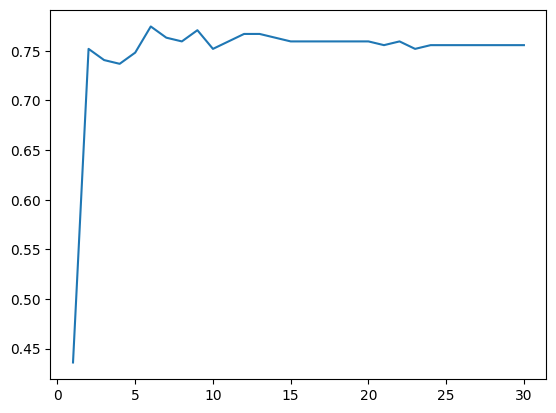

In [92]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 30 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies=[]
recalls=[]
precisions=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy, recall, precision = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    time_taken = time.time() - epoch_start_time
    print(f'Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: {accuracy:.3f}, recall: {recall}, precision: {precision}.')
    
plt.plot(range(1, EPOCHS+1), accuracies)

accuracy, recall, precision = get_accuracy(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')